In [1]:
!pip install fiftyone ultralytics torch torchvision
!pip install wanddb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 112.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.5/934.5 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 k

In [ ]:
import time
import wandb
import os

from ultralytics import YOLO
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.utils.random as four

In [ ]:
os.environ["WANDB_API_KEY"] = "WANDB_API_KEY"

# LOGIN
wandb.login()


True

In [ ]:
YOLO("yolov8m.pt")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_


image 1/1 /kaggle/input/images/imahes8.jpg: 640x608 1 cake, 1 potted plant, 58.6ms
Speed: 12.8ms preprocess, 58.6ms inference, 31.6ms postprocess per image at shape (1, 3, 640, 608)


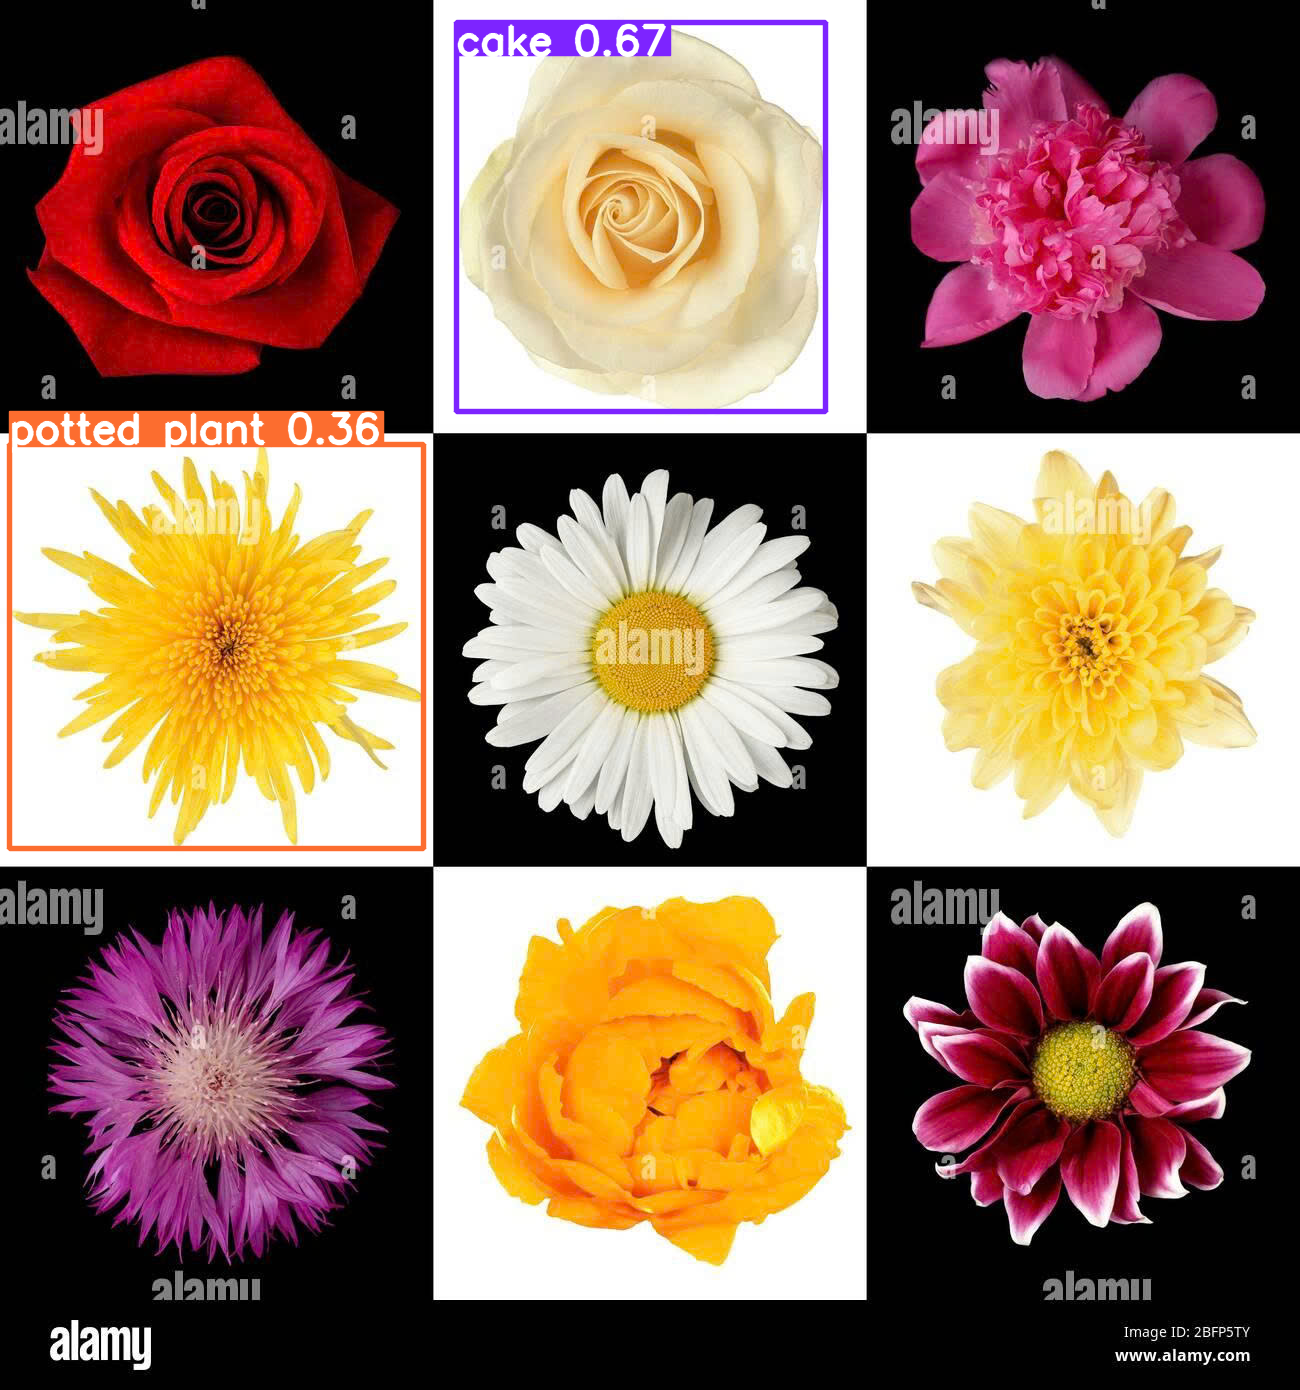

In [5]:
model = YOLO("yolov8m.pt")
results = model("/kaggle/input/images/imahes8.jpg", conf=0.3)
results[0].show()

In [ ]:
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["detections"],
    classes=["Flower"],
    max_samples=5000,
    dataset_name="openimages-flower"
)


Found 2322 images, downloading the remaining 2678
 100% |█████████████████| 2678/2678 [1.8m elapsed, 0s remaining, 25.8 files/s]      
Dataset info written to '/root/fiftyone/open-images-v7/info.json'
Loading 'open-images-v7' split 'train'
 100% |███████████████| 5000/5000 [40.5s elapsed, 0s remaining, 119.6 samples/s]      
Dataset 'openimages-flower' created


In [ ]:
dataset = dataset.filter_labels(
    "ground_truth",
    F("label") == "Flower"
)


In [10]:
dataset.count("ground_truth.detections")


28206

In [ ]:

dataset = fo.load_dataset("openimages-flower")

# Chia train / val
four.random_split(
    dataset,
    {"train": 0.8, "val": 0.2},
    seed=42
)


In [12]:
dataset.export(
    export_dir="flowers_yolo",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    split="train"
)

dataset.export(
    export_dir="flowers_yolo",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    split="val"
)


 100% |███████████████| 5000/5000 [19.5s elapsed, 0s remaining, 247.9 samples/s]      
Directory 'flowers_yolo' already exists; export will be merged with existing files
 100% |███████████████| 5000/5000 [19.0s elapsed, 0s remaining, 176.9 samples/s]      


In [ ]:
model.train(
    data="flowers_yolo/dataset.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    close_mosaic=10,
    patience=15,
    project="YOLO-Flowers",
    device=0,
    verbose=True,
)

wandb.finish()


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=flowers_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspect